In [35]:
# --- Cell 1: Installations ---

# Uninstall the old, conflicting package (if it exists)
!pip uninstall pinecone-client -y

# Install the correct, modern versions of all libraries
!pip install --upgrade pinecone
!pip install --upgrade google-generativeai
!pip install pandas matplotlib


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
# --- Cell 2: Setup & API Keys (Run AFTER restarting)

import pandas as pd
import numpy as np
import os
import timeit
import matplotlib.pyplot as plt
import pinecone
import google.generativeai as genai
import time

# If you added a .env file in the notebook folder, load it into os.environ
# This uses python-dotenv and will attempt to install it if missing.
try:
    from dotenv import load_dotenv
except Exception:
    import sys
    try:
        __import__('subprocess').run([sys.executable, '-m', 'pip', 'install', 'python-dotenv'], check=True)
    except Exception as e:
        print(f"Could not install python-dotenv: {e}")
    from dotenv import load_dotenv

from pathlib import Path
notebook_env_path = Path(r"c:\Users\agarw\OneDrive\Desktop\Rohan\Vibe_Check\.env")
if notebook_env_path.exists():
    load_dotenv(notebook_env_path)
    print(f"Loaded .env from {notebook_env_path}")
else:
    load_dotenv()
    print("Called load_dotenv() from cwd to import .env variables (if present).")

# Try to import Colab userdata
try:
    from google.colab import userdata
    IS_COLAB = True
    print("Running in Google Colab environment.")
except ImportError:
    IS_COLAB = False
    print("Not running in Colab. Will use environment variables.")

# --- Google Gemini API Setup ---
# Note: Your code loads a secret named 'GEMINI_API_KEY'
GOOGLE_API_KEY = None
try:
    if IS_COLAB:
        GOOGLE_API_KEY = userdata.get('GEMINI_API_KEY') # Make sure your secret is named 'GEMINI_API_KEY'
        print("Loaded 'GEMINI_API_KEY' from Colab secrets.")
    else:
        GOOGLE_API_KEY = os.environ.get("GEMINI_API_KEY")
        print("Loaded 'GEMINI_API_KEY' from environment variables.")
        
    if not GOOGLE_API_KEY:
        raise ValueError("GEMINI_API_KEY not found.")
        
    genai.configure(api_key=GOOGLE_API_KEY)
    print("Google Gemini client configured successfully.")
    
except Exception as e:
    print(f"Error initializing Google Gemini client: {e}")
    print("Please create a 'GEMINI_API_KEY' secret in Colab (or set env variable).")


# --- Pinecone API Setup ---
PINECONE_API_KEY = None
pinecone_client = None
try:
    if IS_COLAB:
        PINECONE_API_KEY = userdata.get('PINECONE_API_KEY') # Make sure your secret is named 'PINECONE_API_KEY'
        print("Loaded 'PINECONE_API_KEY' from Colab secrets.")
    else:
        PINECONE_API_KEY = os.environ.get("PINECONE_API_KEY")
        print("Loaded 'PINECONE_API_KEY' from environment variables.")

    if not PINECONE_API_KEY:
         raise ValueError("Pinecone API key not found.")

    # This line will now work
    pinecone_client = pinecone.Pinecone(api_key=PINECONE_API_KEY)
    print("Pinecone client initialized successfully.")
    print(f"Available Pinecone indexes: {pinecone_client.list_indexes()}")

except Exception as e:
    print(f"Error initializing Pinecone client: {e}")
    print("Please create a 'PINECONE_API_KEY' secret in Colab (or set env variable).")

Called load_dotenv() from cwd to import .env variables (if present).
Not running in Colab. Will use environment variables.
Loaded 'GEMINI_API_KEY' from environment variables.
Google Gemini client configured successfully.
Loaded 'PINECONE_API_KEY' from environment variables.
Pinecone client initialized successfully.
Available Pinecone indexes: [{
    "name": "vibe-matcher-gemini",
    "metric": "cosine",
    "host": "vibe-matcher-gemini-mdv3d83.svc.aped-4627-b74a.pinecone.io",
    "spec": {
        "serverless": {
            "cloud": "aws",
            "region": "us-east-1"
        }
    },
    "status": {
        "ready": true,
        "state": "Ready"
    },
    "vector_type": "dense",
    "dimension": 768,
    "deletion_protection": "disabled",
    "tags": null
}]
Available Pinecone indexes: [{
    "name": "vibe-matcher-gemini",
    "metric": "cosine",
    "host": "vibe-matcher-gemini-mdv3d83.svc.aped-4627-b74a.pinecone.io",
    "spec": {
        "serverless": {
            "cloud":

In [37]:
# --- Cell 3: Define Product Data ---

data = {
    "name": [
        "Boho Maxi Dress", "Streetwear Graphic Hoodie", "Tailored Linen Suit",
        "Cozy Cable-Knit Sweater", "Performance Active Leggings", "Vintage Trucker Jacket",
        "Mulberry Silk Pajama Set", "Techwear Cargo Pants", "Minimalist Court Sneaker",
        "Preppy Argyle Vest", "Gothic Lace Blouse", "Utility Field Jacket",
        "Sequin Party Dress", "Y2K Velour Tracksuit", "Coastal-Chic Cardigan"
    ],
    "desc": [
        "A flowy, ankle-length maxi dress featuring intricate paisley floral patterns, earthy tones of terracotta and olive, and delicate tassel ties. Perfect for music festivals, beach vacations, or a relaxed, artistic summer day.",
        "An oversized, heavy-weight cotton hoodie in jet black with a bold, neon graffiti graphic on the back. Features a drop-shoulder cut, thick drawstring hood, and a deep kangaroo pocket. Ideal for an energetic, urban, and edgy streetwear aesthetic.",
        "A meticulously tailored, single-breasted linen suit in a light sand beige. The breathable fabric keeps you cool and sharp, while the structured shoulders provide a modern silhouette. Designed for sophisticated summer weddings, coastal events, or elegant garden parties.",
        "A wonderfully chunky, oversized cable-knit turtleneck sweater made from a soft merino wool blend in a warm cream color. The ribbed cuffs and hem lock in warmth. Perfect for a cozy night in by the fire, reading a good book, or a crisp autumn walk.",
        "Seamless, high-waisted performance leggings in a bold sapphire blue. The four-way stretch and moisture-wicking fabric supports you during high-intensity workouts, yoga sessions, or long-distance running. Features a hidden waistband pocket for your key.",
        "A classic, 1990s-inspired trucker jacket in a medium-wash blue denim. Features authentic, slight distressing on the collar and cuffs, button-flap chest pockets, and a relaxed fit. A timeless, versatile piece for a casual, retro, or layered vibe.",
        "A luxurious, 100% mulberry silk pajama set in a deep emerald green with contrasting white piping. The button-down top and drawstring pants feel incredibly smooth and cool against the skin for a truly relaxing and indulgent evening.",
        "Water-resistant, multi-pocket cargo pants in a matte black technical fabric. Features adjustable ankle straps, multiple zip-pockets, and a futuristic, functional silhouette. Built for navigating the city in all conditions, blending utility with a cyber-punk edge.",
        "A clean, low-top court sneaker crafted from premium white Italian leather. Features a simple, unbranded profile, gold-leaf lettering on the heel, and a comfortable recycled rubber sole. The perfect versatile shoe for a smart-casual or minimalist wardrobe.",
        "A sleeveless, v-neck sweater vest in a classic navy blue and green argyle pattern. Made from a soft cotton-cashmere blend. Ideal for layering over a button-down for a preppy, academic, or 'dark academia' aesthetic.",
        "An elegant, Victorian-inspired blouse in black sheer lace. Features a high ruffled neck, puffed shoulders, velvet ribbon details, and intricate floral detailing. Perfect for a gothic, romantic, or sophisticated evening ensemble.",
        "A rugged, military-inspired field jacket in olive drab cotton twill. Features four large front snap-pockets, a concealed hood in the collar, and an adjustable internal drawstring waist. A durable and practical piece for an outdoor, gorpcore, or utilitarian vibe.",
        "A dazzling, silver sequin mini dress with a plunging v-neck and structured long sleeves. This bodycon dress is fully lined for comfort and designed to catch the light. The ultimate statement piece for a birthday party, New Year's Eve, or a glamorous night out.",
        "A plush, baby pink velour tracksuit set. The zip-up hoodie and matching flared pants (with a low-rise fit) bring back early 2000s nostalgia. Incredibly soft and comfortable for lounging or making a bold, retro fashion statement.",
        "A long, open-front cardigan in a heavy-gauge beige cotton knit. Features a relaxed, slouchy fit, deep side pockets, and a shawl collar. Effortlessly chic and perfect for a breezy walk on the beach or curling up with tea. Embodies a quiet, coastal luxury."
    ],
    "tags": [
        ["boho", "festival", "summer", "maxi", "flowy", "earthy", "artistic", "paisley"],
        ["urban", "streetwear", "edgy", "energetic", "hoodie", "oversized", "graphic", "neon"],
        ["formal", "summer", "elegant", "sophisticated", "wedding", "linen", "tailored", "coastal"],
        ["cozy", "comfortable", "winter", "autumn", "knitwear", "turtleneck", "oversized", "hygge"],
        ["active", "sporty", "energetic", "workout", "yoga", "running", "performance", "athleisure"],
        ["vintage", "casual", "retro", "denim", "jacket", "90s", "timeless", "layering"],
        ["luxury", "cozy", "relax", "pajamas", "silk", "elegant", "loungewear", "indulgent"],
        ["techwear", "urban", "futuristic", "functional", "gorpcore", "streetwear", "cyberpunk", "water-resistant"],
        ["minimalist", "casual", "smart-casual", "sneaker", "versatile", "timeless", "leather", "clean"],
        ["preppy", "academic", "darkacademia", "layering", "vest", "classic", "argyle", "scholarly"],
        ["gothic", "victorian", "lace", "romantic", "elegant", "eveningwear", "sheer", "dark"],
        ["utilitarian", "military", "rugged", "outdoor", "gorpcore", "jacket", "practical", "workwear"],
        ["party", "glamorous", "sequin", "nye", "statement", "eveningwear", "bold", "clubbing"],
        ["y2k", "retro", "2000s", "loungewear", "comfortable", "nostalgic", "velour", "pink"],
        ["coastal", "minimalist", "luxury", "relaxed", "chic", "comfortable", "cardigan", "beach"]
    ]
}

df_products = pd.DataFrame(data)
print(f"--- Product DataFrame Created ({len(df_products)} items) ---")
print(df_products.head())

--- Product DataFrame Created (15 items) ---
                          name  \
0              Boho Maxi Dress   
1    Streetwear Graphic Hoodie   
2          Tailored Linen Suit   
3      Cozy Cable-Knit Sweater   
4  Performance Active Leggings   

                                                desc  \
0  A flowy, ankle-length maxi dress featuring int...   
1  An oversized, heavy-weight cotton hoodie in je...   
2  A meticulously tailored, single-breasted linen...   
3  A wonderfully chunky, oversized cable-knit tur...   
4  Seamless, high-waisted performance leggings in...   

                                                tags  
0  [boho, festival, summer, maxi, flowy, earthy, ...  
1  [urban, streetwear, edgy, energetic, hoodie, o...  
2  [formal, summer, elegant, sophisticated, weddi...  
3  [cozy, comfortable, winter, autumn, knitwear, ...  
4  [active, sporty, energetic, workout, yoga, run...  


In [41]:
# --- Cell 4: Create Embedding Function (with Normalization) ---

import numpy as np

EMBEDDING_MODEL = "models/text-embedding-004"
EMBEDDING_DIMENSION = 768

def get_gemini_embedding(text, task_type, title=None):
    """Generates an embedding for the given text using the Gemini API."""
    if not text:
        return None
    try:
        embed_args = {
            "model": EMBEDDING_MODEL,
            "content": text,
            "task_type": task_type
        }
        if task_type == "RETRIEVAL_DOCUMENT" and title:
            embed_args["title"] = title
            
        result = genai.embed_content(**embed_args)
        return result['embedding'] # Return the raw, unnormalized embedding
    except Exception as e:
        print(f"Error getting embedding (title: {title}): '{text[:50]}...': {e}")
        return None

def normalize_vector(v):
    """Normalizes a vector to have a length (L2 norm) of 1."""
    if v is None:
        return None
    v_array = np.array(v)
    norm = np.linalg.norm(v_array)
    if norm == 0:
        return v
    normalized = v_array / norm
    return normalized.tolist()  # Convert to list for Pinecone

# --- Test the function ---
test_raw_emb = get_gemini_embedding("This is a test", "RETRIEVAL_DOCUMENT", title="Test")
if test_raw_emb:
    print(f"Successfully generated raw embedding with {len(test_raw_emb)} dimensions.")
    test_norm_emb = normalize_vector(test_raw_emb)
    print(f"Normalized vector L2 norm: {np.linalg.norm(test_norm_emb):.2f}") # Should be 1.0
else:
    print("Failed to generate test embedding. Check API key and configuration.")

Successfully generated raw embedding with 768 dimensions.
Normalized vector L2 norm: 1.00


In [39]:
# --- Cell 5: Create & Populate Pinecone Index (COSINE) ---

INDEX_NAME = "vibe-matcher-gemini-cosine" # New name to avoid conflicts

# 1. Delete and recreate the index
if INDEX_NAME in [index.name for index in pinecone_client.list_indexes()]:
    print(f"Deleting existing index: {INDEX_NAME}...")
    pinecone_client.delete_index(INDEX_NAME)
    print(f"Index '{INDEX_NAME}' deleted.")
    time.sleep(2)

# Create the index
print(f"Creating new index: {INDEX_NAME}...")
pinecone_client.create_index(
    name=INDEX_NAME,
    dimension=EMBEDDING_DIMENSION,
    
    # --- FIX: Set metric back to cosine ---
    metric="cosine", 
    
    spec=pinecone.ServerlessSpec(
        cloud="aws",
        region="us-east-1"
    )
)
print("Waiting for index to be ready... (this may take a minute)")
while not pinecone_client.describe_index(INDEX_NAME).status['ready']:
    time.sleep(5)
print(f"Index '{INDEX_NAME}' is ready!")

# 2. Connect to the index
index = pinecone_client.Index(INDEX_NAME)
print(f"\nConnected to index. Stats: {index.describe_index_stats()}")

# 3. Generate embeddings and prepare for upsert
print("\n--- Generating Embeddings and Preparing for Pinecone Upsert ---")
vectors_to_upsert = []

for i, row in df_products.iterrows():
    # Get the raw embedding
    raw_embedding = get_gemini_embedding(
        text=row['desc'],
        task_type="RETRIEVAL_DOCUMENT",
        title=row['name'] 
    )
    
    if raw_embedding:
        # --- FIX: Normalize the embedding before upserting ---
        normalized_embedding = normalize_vector(raw_embedding)
        
        vector_id = str(i) 
        metadata = {"product_name": row['name'], "desc": row['desc']}
        
        vectors_to_upsert.append({
            "id": vector_id,
            "values": normalized_embedding, # Upsert the normalized vector
            "metadata": metadata
        })
        print(f"Generated & normalized embedding for item {i}: {row['name']}")
    else:
        print(f"Failed to generate embedding for item {i}: {row['name']}")

# 4. Upsert the vectors in a batch
if vectors_to_upsert:
    print(f"\n--- Upserting {len(vectors_to_upsert)} vectors to Pinecone ---")
    index.upsert(vectors=vectors_to_upsert)
    print("Upsert complete.")
    print(f"Index stats after upsert: {index.describe_index_stats()}")

Creating new index: vibe-matcher-gemini-cosine...
Waiting for index to be ready... (this may take a minute)
Waiting for index to be ready... (this may take a minute)
Index 'vibe-matcher-gemini-cosine' is ready!
Index 'vibe-matcher-gemini-cosine' is ready!

Connected to index. Stats: {'dimension': 768,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {},
 'total_vector_count': 0,
 'vector_type': 'dense'}

--- Generating Embeddings and Preparing for Pinecone Upsert ---

Connected to index. Stats: {'dimension': 768,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {},
 'total_vector_count': 0,
 'vector_type': 'dense'}

--- Generating Embeddings and Preparing for Pinecone Upsert ---
Generated & normalized embedding for item 0: Boho Maxi Dress
Generated & normalized embedding for item 0: Boho Maxi Dress
Generated & normalized embedding for item 1: Streetwear Graphic Hoodie
Generated & normalized embedding for item 1: Streetwear Graphic Hoodie
Generated & normalized emb

In [42]:
# --- Cell 6: Create Search Function (COSINE) ---

def find_vibe_matches_pinecone(query, index, top_n=3, no_match_threshold=0.7):
    """
    Finds the top_n most similar products using a Pinecone index
    and the Gemini embedding model with COSINE similarity.
    """
    # 1. Get the raw query embedding
    raw_query_embedding = get_gemini_embedding(query, task_type="RETRIEVAL_QUERY")
    
    if raw_query_embedding is None:
        return "Error: Could not embed query."

    # --- FIX: Normalize the query embedding before search ---
    normalized_query_embedding = normalize_vector(raw_query_embedding)

    # 2. Query Pinecone
    query_response = index.query(
        vector=normalized_query_embedding, # Use the normalized query vector
        top_k=top_n,
        include_metadata=True 
    )
    
    # 3. Process the results
    matches = query_response['matches']
    
    # 4. Handle Edge Case: No Good Match
    if not matches or matches[0]['score'] < no_match_threshold:
        fallback_message = "No strong vibe match found. Try rephrasing your vibe!"
        if matches:
             fallback_message = (
                f"No strong vibe match found (top score: {matches[0]['score']:.4f}). "
                "Try rephrasing your vibe!"
             )
        return fallback_message

    # 5. Format results into a nice DataFrame
    results_list = []
    for match in matches:
        results_list.append({
            "name": match['metadata']['product_name'],
            "desc": match['metadata']['desc'],
            "similarity_score": match['score']
        })
    
    return pd.DataFrame(results_list)

# --- Test with the sample query from your image ---
sample_query = "energetic urban chic"
print(f"--- Running Sample Query with Pinecone + Gemini (COSINE): '{sample_query}' ---")
print(find_vibe_matches_pinecone(sample_query, index))

--- Running Sample Query with Pinecone + Gemini (COSINE): 'energetic urban chic' ---
No strong vibe match found (top score: 0.5447). Try rephrasing your vibe!
No strong vibe match found (top score: 0.5447). Try rephrasing your vibe!



--- Starting Test & Evaluation (Gemini + Pinecone + COSINE) ---

Query: 'energetic urban chic'
Latency: 1254.79 ms
Results:
No strong vibe match found (top score: 0.5447). Try rephrasing your vibe!
--------------------

Query: 'energetic urban chic'
Latency: 1254.79 ms
Results:
No strong vibe match found (top score: 0.5447). Try rephrasing your vibe!
--------------------

Query: 'something cozy for a cold night'
Latency: 1119.15 ms
Results:
No strong vibe match found (top score: 0.6653). Try rephrasing your vibe!
--------------------

Query: 'something cozy for a cold night'
Latency: 1119.15 ms
Results:
No strong vibe match found (top score: 0.6653). Try rephrasing your vibe!
--------------------

Query: 'what to wear to a summer wedding'
Latency: 1059.03 ms
Results:
No strong vibe match found (top score: 0.5054). Try rephrasing your vibe!
--------------------

--- Evaluation Metrics Summary ---
| query                            |   top_score |   latency_ms | is_good_match   |
|:----

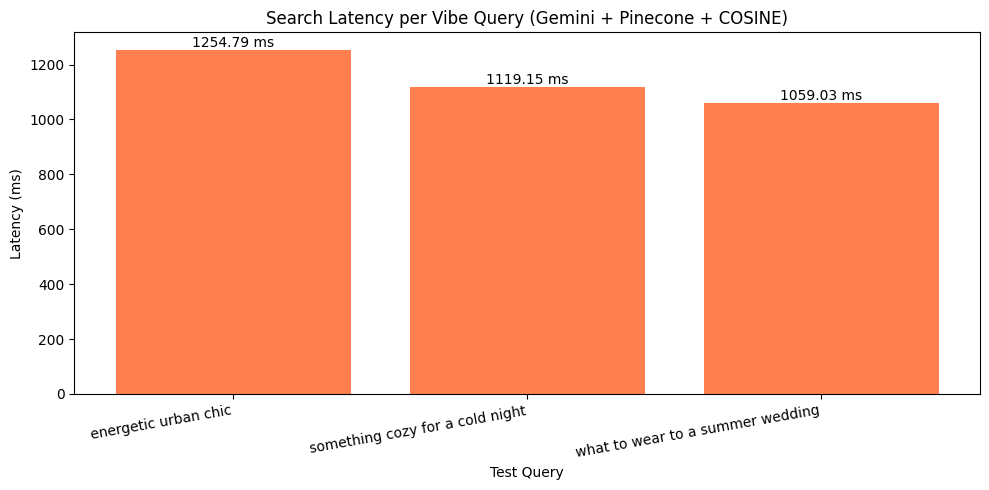

In [43]:
# --- Cell 7: Test & Eval (Simple) ---

# Define the 3 test queries
test_queries = [
    "energetic urban chic",           # Should match Hoodie, maybe Techwear
    "something cozy for a cold night",  # Should match Sweater, maybe Pajamas, Cardigan
    "what to wear to a summer wedding"  # Should match Linen Suit
]

eval_log = []
GOOD_THRESHOLD = 0.7 

print("\n--- Starting Test & Evaluation (Gemini + Pinecone + COSINE) ---")

for query in test_queries:
    # 1. Measure Latency
    start_time = timeit.default_timer()
    results = find_vibe_matches_pinecone(query, index, no_match_threshold=GOOD_THRESHOLD)
    end_time = timeit.default_timer()
    
    latency_ms = (end_time - start_time) * 1000 # Convert to milliseconds
    
    # 2. Log Metrics
    top_score = 0.0
    is_good_match = False
    
    if isinstance(results, pd.DataFrame): # Check if we got results
        top_score = results.iloc[0]['similarity_score']
        is_good_match = top_score > GOOD_THRESHOLD
    
    log_entry = {
        "query": query,
        "top_score": top_score,
        "latency_ms": latency_ms,
        "is_good_match": is_good_match
    }
    eval_log.append(log_entry)
    
    # Print results for this query
    print(f"\nQuery: '{query}'")
    print(f"Latency: {latency_ms:.2f} ms")
    print("Results:")
    print(results)
    print("-" * 20)

# 3. Display Metrics Log
eval_df = pd.DataFrame(eval_log)
print("\n--- Evaluation Metrics Summary ---")
print(eval_df.to_markdown(index=False, floatfmt=".4f"))

# 4. Plot Latency
plt.figure(figsize=(10, 5))
bars = plt.bar(eval_df['query'], eval_df['latency_ms'], color='coral')
plt.xlabel("Test Query")
plt.ylabel("Latency (ms)")
plt.title("Search Latency per Vibe Query (Gemini + Pinecone + COSINE)")
plt.xticks(rotation=10, ha='right')
plt.bar_label(bars, fmt='%.2f ms')
plt.tight_layout()
plt.show()